# FitzHugh-Nagumo Model

This notebook will produce example data for the FitzHugh-Nagumo Model and then identify the underlying partial differential equations.

## Time simulation

The `tsme` package provides a number of pre-implemented dynamical systems, so we simply import the class `FitzHughNagumo`. (See this [page](https://nonlinear-physics.zivgitlabpages.uni-muenster.de/ag-kamps/tsme/source/tsme.premade_models.html) for more models.)

In [1]:
%%capture
%cd ..
import numpy as np
from tsme.premade_models import FitzHughNagumo

The FitzHugh-Nagumo equation can be written as follows:
$$
\begin{align}
f &= \lambda \, u - u^3 - \kappa \\
\frac{\text{d}u}{\text{d}t} &= D_u^2 \, \nabla^2 u + f - \omega \, v \\
\tau \, \frac{\text{d}v}{\text{d}t} &= D_v^2 \, \nabla^2 v + u - v,
\end{align}
$$
with $u(x, y)$ and $v(x, y)$.

As we are dealing with a spatially extended 2D system we first set our spatial disctretization and domain sizes in $x$ and $y$ direction respectively.  Then we define a time interval as well as the time stamps at which we want to sample our trajectory. The initial condition is set to random noise between -0.25 and +0.25 for both fields.

In [2]:
N = 256
Lx = 128
Ly = 128
domain = ((0, Lx), (0, Ly))
time = np.linspace(0, 90, 250)

In [3]:
u0 = (np.random.random((N, N)) - 0.5) * 0.5
v0 = (np.random.random((N, N)) - 0.5) * 0.5

In [4]:
fhn = FitzHughNagumo(ic=np.array([u0, v0]), dom=domain, params=[0.5, 0.5, 0.5, 0.5, 0., 15])
sol = fhn.simulate([time[0], time[-1]], method="DOP853", t_eval=time)

IVP: 100%|##########| 90.0/90.0 [03:58<00:00,  2.65s/ut]                


In [5]:
%%capture
from tsme.utils.visualization import animate
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.axis("off")
anima = animate(sol, fig=fig, ax=ax, interval=60)
plt.close(fig)

In [6]:
from IPython import display
display.HTML(anima.to_html5_video())

In [7]:
from tsme.model_estimation import Model

In [13]:
estimated_model = Model(sol[:, :50], time[:50], phys_domain=domain)
estimated_model.init_library(3, 2)
estimated_model.print_library()

|   Index | Term                          |   Value 0 |   Value 1 |
|---------|-------------------------------|-----------|-----------|
|       0 | 1.0                           |         0 |         0 |
|       1 | u[0]                          |         0 |         0 |
|       2 | u[1]                          |         0 |         0 |
|       3 | u[0]*u[0]                     |         0 |         0 |
|       4 | u[0]*u[1]                     |         0 |         0 |
|       5 | u[1]*u[1]                     |         0 |         0 |
|       6 | u[0]*u[0]*u[0]                |         0 |         0 |
|       7 | u[0]*u[0]*u[1]                |         0 |         0 |
|       8 | u[0]*u[1]*u[1]                |         0 |         0 |
|       9 | u[1]*u[1]*u[1]                |         0 |         0 |
|      10 | d_dx(u[0],1)                  |         0 |         0 |
|      11 | d_dy(u[0],1)                  |         0 |         0 |
|      12 | d_dx(u[1],1)                  |     

In [14]:
estimated_model.init_simulator()
estimated_model.optimize_sigma(lamb=0.001, thres=0.001, error="SINDy", backend="train")
sigma_SINDy = estimated_model.sigma

Generating library functions (this may take some time)...


Training sequencing threshold ridge regression with SINDy  error: 100%|██████████| 10/10 [07:46<00:00, 46.65s/it, Threshold=0.01, Error=118]

New Sigma set to: 

|   Index | Term                   |    Value 0 |    Value 1 |
|---------|------------------------|------------|------------|
|       1 | u[0]                   |  0.270821  |  0.0600729 |
|       2 | u[1]                   | -0.345906  | -0.0464009 |
|       6 | u[0]*u[0]*u[0]         | -0.346426  |  0         |
|       7 | u[0]*u[0]*u[1]         | -0.151713  |  0         |
|       8 | u[0]*u[1]*u[1]         | -0.0601438 |  0         |
|       9 | u[1]*u[1]*u[1]         | -0.0229559 |  0         |
|      28 | d_dx(u[0],2)           |  0.134128  |  0         |
|      29 | d_dy(u[0],2)           |  0.133115  |  0         |
|      31 | d_dx(u[1],2)           |  0         |  0.0174891 |
|      32 | d_dy(u[1],2)           |  0         |  0.0175081 |
|      43 | d_dx(u[0]*u[0]*u[0],2) | -0.125956  |  0         |
|      44 | d_dy(u[0]*u[0]*u[0],2) | -0.108335  |  0         |
|      46 | d_dx(u[0]*u[0]*u[1],2) | -0.0507047 |  0         |
|      47 | d_dy(u[0]*u[0]*u[1],2) 

In [17]:
estimated_model.optimize_sigma(error="BIC", backend="hyperopt", max_evals=30, space={"type": "log", "bounds": [-5, -2]})
sigma_BIC = estimated_model.sigma

New Sigma set to: 

|   Index | Term                          |   Value 0 |    Value 1 |
|---------|-------------------------------|-----------|------------|
|       0 | 1.0                           |  0        |  0         |
|       1 | u[0]                          |  0.430819 |  0.0662476 |
|       2 | u[1]                          | -0.465463 | -0.066386  |
|       3 | u[0]*u[0]                     |  0        |  0         |
|       4 | u[0]*u[1]                     |  0        |  0         |
|       5 | u[1]*u[1]                     |  0        |  0         |
|       6 | u[0]*u[0]*u[0]                | -1.0332   |  0         |
|       7 | u[0]*u[0]*u[1]                |  1.56989  |  0.0268801 |
|       8 | u[0]*u[1]*u[1]                | -4.76546  | -0.122342  |
|       9 | u[1]*u[1]*u[1]                |  4.36671  |  0.141679  |
|      10 | d_dx(u[0],1)                  |  0        |  0         |
|      11 | d_dy(u[0],1)                  |  0        |  0         |
|      12 | d_

In [19]:
estimated_model.print_library(reduced=True)

|   Index | Term                   |   Value 0 |    Value 1 |
|---------|------------------------|-----------|------------|
|       1 | u[0]                   |  0.430819 |  0.0662476 |
|       2 | u[1]                   | -0.465463 | -0.066386  |
|       6 | u[0]*u[0]*u[0]         | -1.0332   |  0         |
|       7 | u[0]*u[0]*u[1]         |  1.56989  |  0.0268801 |
|       8 | u[0]*u[1]*u[1]         | -4.76546  | -0.122342  |
|       9 | u[1]*u[1]*u[1]         |  4.36671  |  0.141679  |
|      28 | d_dx(u[0],2)           |  0.149148 |  0         |
|      29 | d_dy(u[0],2)           |  0.14911  |  0         |
|      31 | d_dx(u[1],2)           |  0        |  0.0168438 |
|      32 | d_dy(u[1],2)           |  0        |  0.0168518 |
|      43 | d_dx(u[0]*u[0]*u[0],2) | -0.162605 |  0         |
|      44 | d_dy(u[0]*u[0]*u[0],2) | -0.128341 |  0         |
|      49 | d_dx(u[0]*u[1]*u[1],2) | -0.291446 |  0         |
|      50 | d_dy(u[0]*u[1]*u[1],2) | -0.289453 |  0         |


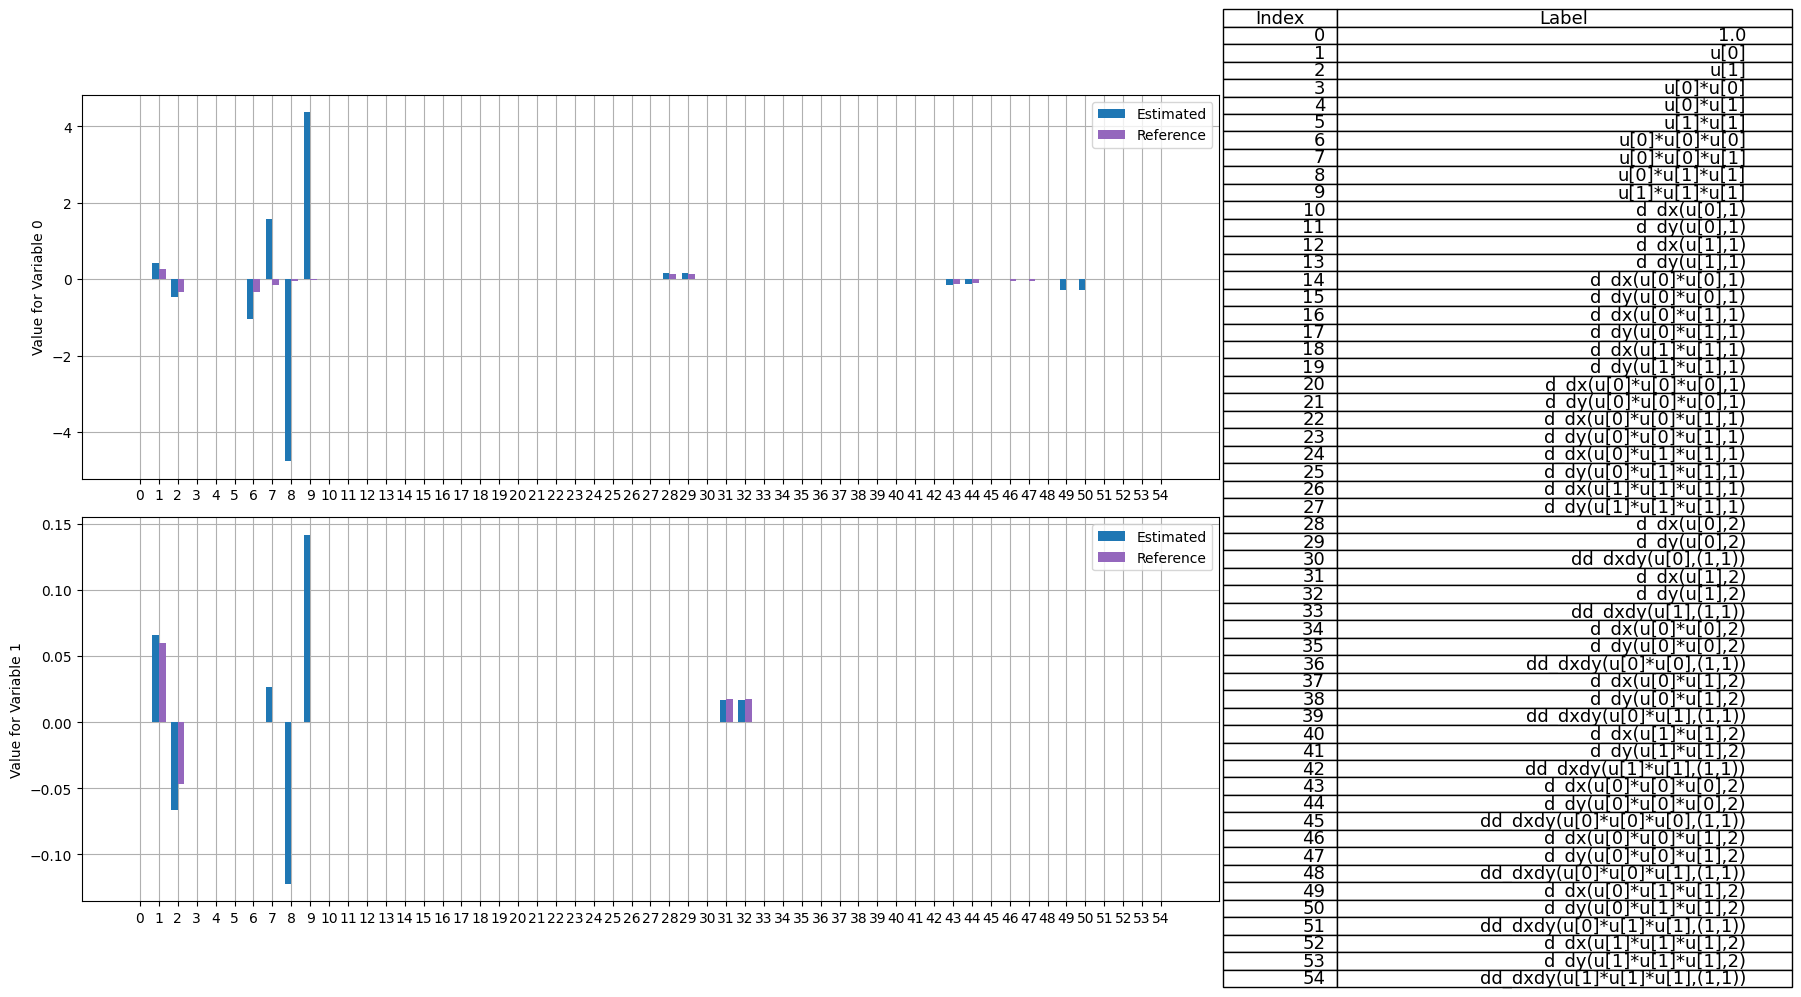

In [20]:
from tsme.utils.visualization import barplot_parameters

labels = estimated_model.print_strings
barplot_parameters(sigma_BIC, sigma_ref=sigma_SINDy, labels=labels, figsize=(18, 10), table_fontsize=13)